Accessing and Querying loaded concrete data from ArangoDB
=========================================================
In this section we try to access data loaded and perform some simple queries on the database. Lets first connect with the database  

In [1]:
import sys
sys.path.append("..")
from MatODM.Databases import ArangoDatabase
import json
with open("db_login_data.json","r") as f:
    logindata = json.load(f)
db = ArangoDatabase(logindata["dbname"], logindata["url"],logindata["user"], logindata["password"],verify_override =False) 
db.collection_names

['Mixes', 'Strengths']

Let us first get random document from Strengths collection.

In [2]:
rand_doc_strength = db.get_random_doc('Strengths')
rand_doc_strength

Strength(mix=RelationalData(_id='Mixes/121023', ODM_doc_type='Mix', collection='Mixes'), age=PhysicalQty(value=28, unit='day', std_dev=None, experimental_technique=None, preferred_unit='day'), strength=PhysicalQty(value=69.83702404, unit='MPa', std_dev=None, experimental_technique=None, preferred_unit='MPa'))

Let us try to now get mix that corresponds to this strength document

In [3]:
rand_doc_mix = db.get_doc("Mixes",rand_doc_strength.mix._id)
rand_doc_mix

Mix(name='Mix405', constituent_amounts={'cement': PhysicalQty(value=500, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'water': PhysicalQty(value=151, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'coarse_agg': PhysicalQty(value=1033, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'fine_agg': PhysicalQty(value=655, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'superplasticizer': PhysicalQty(value=9, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3')}, has_fly_ash=False, has_superplasticizer=True, has_blast_furnace_slag=False)

It should be noted that when invoking get_random_doc or get_doc we get back the MatODM object instance. This is default behaviour and one could also simply get Json ouput as shown below

In [4]:
db.get_doc("Mixes",rand_doc_strength.mix._id,return_as_obj=False)

{'_key': '121023',
 '_id': 'Mixes/121023',
 '_rev': '_fDDFUlS---',
 'name': 'Mix405',
 'constituent_amounts': {'cement': {'value': 500,
   'unit': 'kg m^-3',
   'preferred_unit': 'kg m^-3',
   'ODM_field_type': 'PhysicalQty'},
  'water': {'value': 151,
   'unit': 'kg m^-3',
   'preferred_unit': 'kg m^-3',
   'ODM_field_type': 'PhysicalQty'},
  'coarse_agg': {'value': 1033,
   'unit': 'kg m^-3',
   'preferred_unit': 'kg m^-3',
   'ODM_field_type': 'PhysicalQty'},
  'fine_agg': {'value': 655,
   'unit': 'kg m^-3',
   'preferred_unit': 'kg m^-3',
   'ODM_field_type': 'PhysicalQty'},
  'superplasticizer': {'value': 9,
   'unit': 'kg m^-3',
   'preferred_unit': 'kg m^-3',
   'ODM_field_type': 'PhysicalQty'}},
 'has_fly_ash': False,
 'has_superplasticizer': True,
 'has_blast_furnace_slag': False,
 'water_cement_ratio': 0.302,
 'water_binder_ratio': 0.302,
 'ODM_doc_type': 'Mix',
 'created_on': '2022-11-07 09:48:28 W. Europe Standard Time',
 'version': 0}

Once we have established how to get documents with id or fetch a random document let us try to get some specific type of information from the database. Lets first try to get data for a specific mix name e.g. Mix105.  For this we need to first create a query template  our document give it to find function.

In [5]:
from MatODM import Documents
mix_template = Documents.Mix.example_template()
mix_template.name = "Mix105"
db.find(mix_template)[0] #as we know there is only one mix with this name

Mix(name='Mix105', constituent_amounts={'cement': PhysicalQty(value=401.8, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'water': PhysicalQty(value=147.4, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'coarse_agg': PhysicalQty(value=946.8, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'fine_agg': PhysicalQty(value=852.1, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'blast_furnance_slag': PhysicalQty(value=94.7, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3'), 'superplasticizer': PhysicalQty(value=11.4, unit='kg m^-3', std_dev=None, experimental_technique=None, preferred_unit='kg m^-3')}, has_fly_ash=False, has_superplasticizer=True, has_blast_furnace_slag=True)

We can perform more complex query with find function for instance getting only OPC concrete without super plasticizers. As we have stored  keys has_fly_ash, has_superplasticizer and has_blast_furnace_slag we just need to set them false in template.

In [6]:
mix_template = Documents.Mix.example_template()
mix_template.has_fly_ash = False
mix_template.has_superplasticizer = False
mix_template.has_blast_furnace_slag = False
opc_mixes = db.find(mix_template)
print(f"number of opc mixes: {len(opc_mixes)}")

number of opc mixes: 209


Using OPC mixes output we can not get corresponding strengths from Strengths collection and plot a walz-curve (i.e., water-cement ratio vs strength curve). For this we first sort our data as an array containing water-cement ratio and strength for 28 days age. To get strength from mixes we have obtained in query above we convert first mix to a RelationalData field which is then matched with the database to get corresponding strength value. This is shown as an example below

In [7]:
from MatODM import Fields
strength_template = Documents.Strength.example_template()
strength_template.mix = Fields.RelationalData.init_from_odm_doc(opc_mixes[0])
db.find(strength_template)

[Strength(mix=RelationalData(_id='Mixes/119439', ODM_doc_type='Mix', collection='Mixes'), age=PhysicalQty(value=28, unit='day', std_dev=None, experimental_technique=None, preferred_unit='day'), strength=PhysicalQty(value=39.28978986, unit='MPa', std_dev=None, experimental_technique=None, preferred_unit='MPa'))]

In [8]:
opc_mixes[0]._id

'Mixes/119439'

Lets now loop over all mixes and get corresponding strength values

In [9]:
strengths = []
for mix in opc_mixes:
    strength_template = Documents.Strength.example_template()
    strength_template.mix = Fields.RelationalData.init_from_odm_doc(mix)
    strengths.append(db.find(strength_template)[0])  #as we know there is one to one relationship between mix and strength
print(f"number of strength documents corresponding to opc mixes: {len(strengths)}")

number of strength documents corresponding to opc mixes: 209


In [10]:
#lets figure out what are unique set of ages  for strength
unique_ages=  []
for strength in strengths:
    unique_ages.append(strength.age.value)
import numpy as np
unique_ages=np.unique(unique_ages)
print(unique_ages)

[  1   3   7  14  28  56  90 100 120 180 270 360 365]


Let's now get w/c ratio and corresponding strength for mixes at 28 days and plot the data 

In [11]:
strength_at_28_days =[ ]
wc_at_28_days = []
for i, strength in enumerate(strengths):
    if strength.age == Fields.age(28,"day"):
        strength_at_28_days.append(strength.strength.value)
        wc_at_28_days.append(opc_mixes[i].water_cement_ratio)
strength_unit = strength.strength.unit

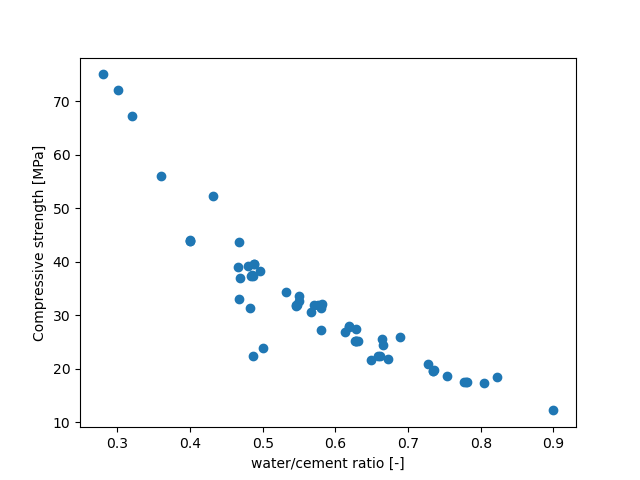

In [12]:
import matplotlib.pylab as plt
%matplotlib widget
plt.figure()
plt.plot(wc_at_28_days,strength_at_28_days, "o")
plt.xlabel("water/cement ratio [-]")
plt.ylabel(f"Compressive strength [{strength_unit}]")
plt.show()

We can also query to figure out strength enteries which are in certain range and work our way to find the corresponding mixes. To get strength with certain range we use find_in_range_of_field method of db.  This is now demonstrated below 

In [13]:
db.find_in_range_of_field?

Signature:
db.find_in_range_of_field(
    collection_name: str,
    field: str,
    minval: [<class 'int'>, <class 'float'>, <class 'MatODM.Fields.PhysicalQty'>],
    maxval: [<class 'int'>, <class 'float'>, <class 'MatODM.Fields.PhysicalQty'>],
    return_as_obj=True,
    *args,
    **kwargs,
)
Docstring: <no docstring>
File:      d:\switchdrive\codes\matodm\matodm\databases\abstract.py
Type:      method


In [14]:
doc_with_strength_40_and_60=db.find_in_range_of_field("Strengths","strength",Fields.strength(40,"MPa"),Fields.strength(60,"MPa"))
print(f"number of entries between 40 and 60 MPa strength values: {len(doc_with_strength_40_and_60)}")

number of entries between 40 and 60 MPa strength values: 285


In [15]:
#lets now obtain corresponding mixes 
mixes_with_strength_40_and_60 = []
for doc in doc_with_strength_40_and_60:
    mixes_with_strength_40_and_60.append(db.get_doc("Mixes",doc.mix._id))
print(f"number of mixes with strength between 40 and 60 MPa: {len(mixes_with_strength_40_and_60)}")

number of mixes with strength between 40 and 60 MPa: 285


Now that we have mixes we can make quick stats on how many mix are opc mixes, opc containing superplasticizers, mixes containing flyash and mixes containing blast furnance slag and plot a pychart.

opc:35, opc + sp: 13, opc + fly-ash:137 + opc + blast furnance slag: 100


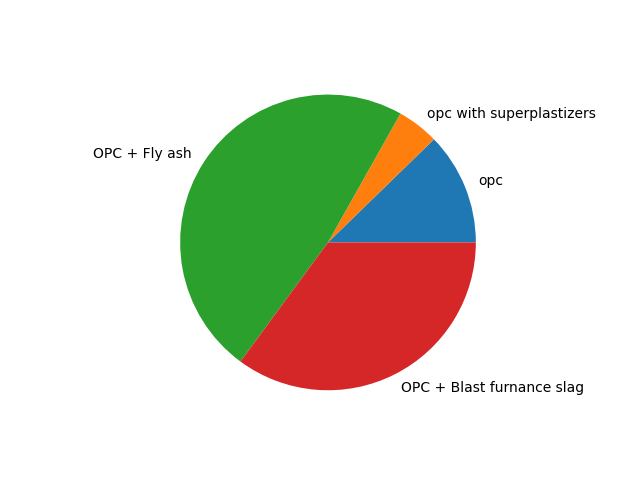

In [16]:
opc = 0
opc_with_sp = 0
opc_with_fa = 0
opc_with_bs = 0 
for mix in mixes_with_strength_40_and_60:
    if (mix.has_fly_ash == False) and (mix.has_superplasticizer == False) and (mix.has_blast_furnace_slag == False):
        opc+=1
    elif  (mix.has_fly_ash == False) and (mix.has_superplasticizer == True) and (mix.has_blast_furnace_slag == False):
        opc_with_sp +=1
    elif mix.has_fly_ash == True:
        opc_with_fa +=1
    elif mix.has_blast_furnace_slag == True:
        opc_with_bs+=1 
print(f"opc:{opc}, opc + sp: {opc_with_sp}, opc + fly-ash:{opc_with_fa} + opc + blast furnance slag: {opc_with_bs}")
plt.figure()
plt.pie([opc,opc_with_sp,opc_with_fa,opc_with_bs], labels= ["opc","opc with superplastizers", "OPC + Fly ash","OPC + Blast furnance slag"])
plt.show()